# Dijkstra's algorithm

https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm


(city, ([(neighbor, weight)], current_distance, visited, path))

In [1]:
import networkx as nx

G = nx.DiGraph()
G.add_weighted_edges_from([
    ("A", "B", 3.0), ("A", "C", 10.0), ("A", "E", 4.0),
    ("B", "C", 2.0), ("B", "D", 8.0),  ("B", "F", 7.0),
    ("C", "D", 5.0), ("C", "G", 3.0),
    ("D", "H", 6.0),
    ("E", "F", 2.0), ("E", "I", 9.0),
    ("F", "G", 1.0), ("F", "J", 5.0),
    ("G", "H", 2.0), ("G", "K", 4.0),
    ("I", "J", 3.0),
    ("J", "K", 6.0)
])

# or https://networkx.org/documentation/stable/reference/generators.html
# G = nx.barabasi_albert_graph(100, 3)
# G = nx.watts_strogatz_graph(100, 4, 0.1)
# G = nx.random_geometric_graph(100, 0.1)
# G = nx.random_k_out_graph(100, 4, 0.5)
# G = nx.random_k_graph(100, 4)
# G = nx.random_power_law_graph(100, 3, 0.1)


In [2]:
pyspark_graph = []

for node in G.nodes():
    neighbors = [(nbr, G.edges[node, nbr]["weight"]) for nbr in G.successors(node)]
    if node == "A":
        weight = 0
    else:
        weight = float("inf")
    pyspark_graph.append(
        (node, (neighbors, weight, False, []))
    )

In [3]:
for city in pyspark_graph:
    print(city)



('A', ([('B', 3.0), ('C', 10.0), ('E', 4.0)], 0, False, []))
('B', ([('C', 2.0), ('D', 8.0), ('F', 7.0)], inf, False, []))
('C', ([('D', 5.0), ('G', 3.0)], inf, False, []))
('E', ([('F', 2.0), ('I', 9.0)], inf, False, []))
('D', ([('H', 6.0)], inf, False, []))
('F', ([('G', 1.0), ('J', 5.0)], inf, False, []))
('G', ([('H', 2.0), ('K', 4.0)], inf, False, []))
('H', ([], inf, False, []))
('I', ([('J', 3.0)], inf, False, []))
('J', ([('K', 6.0)], inf, False, []))
('K', ([], inf, False, []))


Interpretation:
('A', ([('B', 3.0), ('C', 10.0), ('E', 4.0)], inf, False, []))

Peaje...
A -> B 3€ 
  -> E 4€
  -> C 10€

inf -> Puede ser 0, como ciudad de origen

In [5]:
from pyspark.sql import SparkSession

# Build a local Spark session (works in Databricks/colab/Zeppelin too).
spark = SparkSession.builder.master("local[*]").appName("RDDShortestPaths").getOrCreate()
sc = spark.sparkContext


def initialize_rdd(graph_def, source):
    """Normalize the graph so the source starts at distance 0 and others at inf."""
    normalized = []
    for node, (neighbors, _dist, _visited, _path) in graph_def:
        start_dist = 0.0 if node == source else float("inf")
        start_path = [node] if node == source else []
        normalized.append((node, (neighbors, start_dist, False, start_path)))
    return sc.parallelize(normalized)


def emit_proposals(row):
    """Create relaxation proposals for each neighbor from the current node distance."""
    node, (neighbors, dist, _visited, path) = row
    if dist == float("inf"):
        return []  # unreachable nodes emit nothing
    current_path = path if path else [node]
    return [(nbr, (dist + weight, current_path + [nbr])) for nbr, weight in neighbors]


def relax_once(rdd):
    """One relaxation step: compute best proposals per node and merge with current state."""
    proposals = (
        rdd.flatMap(emit_proposals)
           .reduceByKey(lambda a, b: a if a[0] <= b[0] else b)
    )
    return (
        rdd.leftOuterJoin(proposals)
           .map(merge_update)
    )


def merge_update(item):
    node, ((neighbors, dist, visited, path), proposal) = item
    if proposal is None:
        return (node, (neighbors, dist, visited, path))
    new_dist, new_path = proposal
    if new_dist < dist:
        return (node, (neighbors, new_dist, visited, new_path))
    return (node, (neighbors, dist, visited, path))


def run_shortest_paths(graph_def, source, max_iters=50):
    """Iteratively relax edges until no distances change or max_iters is reached."""
    rdd = initialize_rdd(graph_def, source).cache()
    for _ in range(max_iters):
        next_rdd = relax_once(rdd).cache()
        changes = (
            rdd.join(next_rdd)
               .filter(lambda kv: kv[1][0][1] != kv[1][1][1])
               .count()
        )
        rdd.unpersist()
        rdd = next_rdd
        if changes == 0:
            break
    return dict(rdd.collect())


In [6]:
results = run_shortest_paths(pyspark_graph, "A")
for city, (_neighbors, dist, _visited, path) in sorted(results.items()):
    route = " -> ".join(path) if path else "unreachable"
    dist_str = f"{dist:.1f}" if dist != float("inf") else "inf"
    print(f"{city}: {dist_str} via {route}")


A: 0.0 via A
B: 3.0 via A -> B
C: 5.0 via A -> B -> C
D: 10.0 via A -> B -> C -> D
E: 4.0 via A -> E
F: 6.0 via A -> E -> F
G: 7.0 via A -> E -> F -> G
H: 9.0 via A -> E -> F -> G -> H
I: 13.0 via A -> E -> I
J: 11.0 via A -> E -> F -> J
K: 11.0 via A -> E -> F -> G -> K


In [7]:
graph_line = [
    ("1", ([("2", 1.0)], float("inf"), False, [])),
    ("2", ([("3", 1.0)], float("inf"), False, [])),
    ("3", ([], float("inf"), False, [])),
]

graph_triangle = [
    ("1", ([("2", 2.0), ("3", 4.5)], float("inf"), False, [])),
    ("2", ([("3", 1.5)], float("inf"), False, [])),
    ("3", ([], float("inf"), False, [])),
]

graph_square = [
    ("1", ([("2", 3.0), ("4", 7.0)], float("inf"), False, [])),
    ("2", ([("3", 2.5)], float("inf"), False, [])),
    ("3", ([("4", 1.0)], float("inf"), False, [])),
    ("4", ([], float("inf"), False, [])),
]

extra_examples = {
    "line": graph_line,
    "triangle": graph_triangle,
    "square": graph_square,
}

for name, graph_def in extra_examples.items():
    print(f"\nExample graph: {name}")
    results = run_shortest_paths(graph_def, "1")
    for city, (_neighbors, dist, _visited, path) in sorted(results.items()):
        route = " -> ".join(path) if path else "unreachable"
        dist_str = f"{dist:.1f}" if dist != float("inf") else "inf"
        print(f"  {city}: {dist_str} via {route}")



Example graph: line
  1: 0.0 via 1
  2: 1.0 via 1 -> 2
  3: 2.0 via 1 -> 2 -> 3

Example graph: triangle
  1: 0.0 via 1
  2: 2.0 via 1 -> 2
  3: 3.5 via 1 -> 2 -> 3

Example graph: square
  1: 0.0 via 1
  2: 3.0 via 1 -> 2
  3: 5.5 via 1 -> 2 -> 3
  4: 6.5 via 1 -> 2 -> 3 -> 4


/tmp/ipython-input-1256479848.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(destinations), 1))


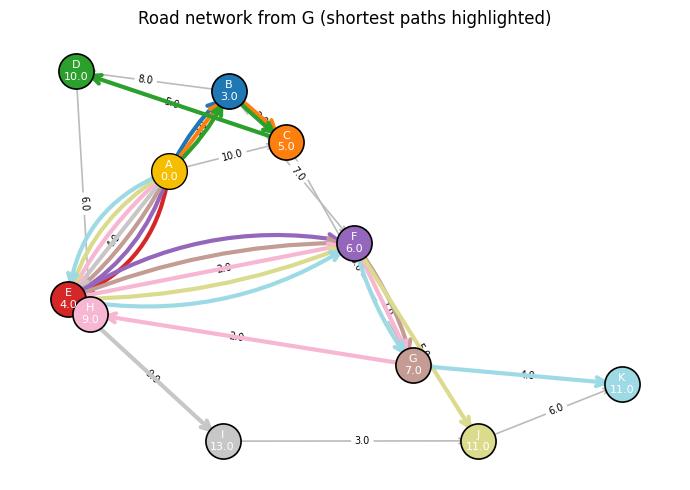

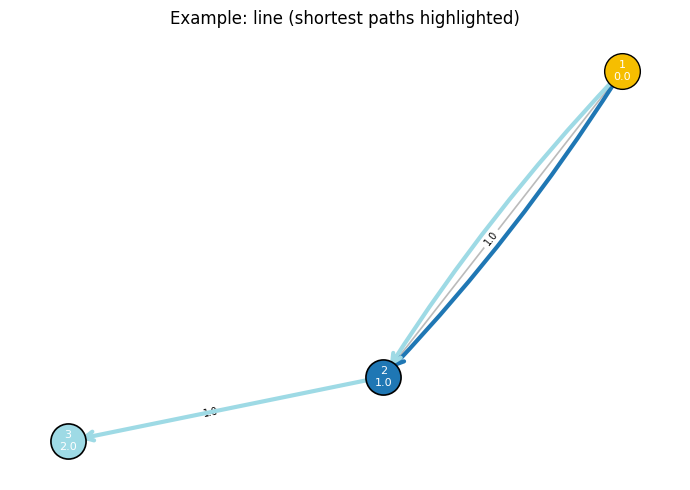

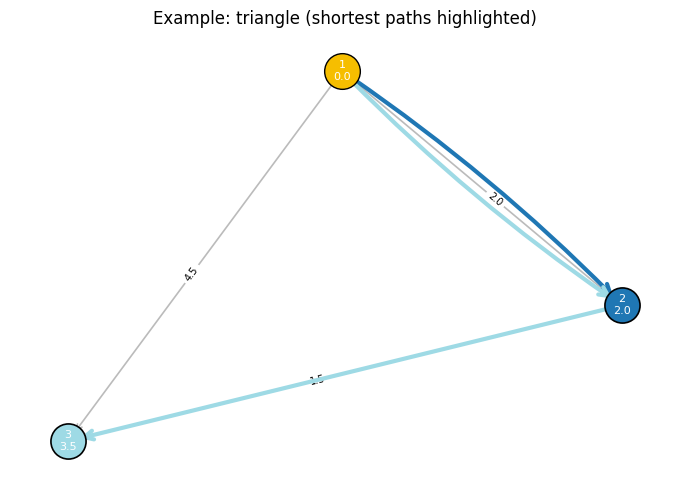

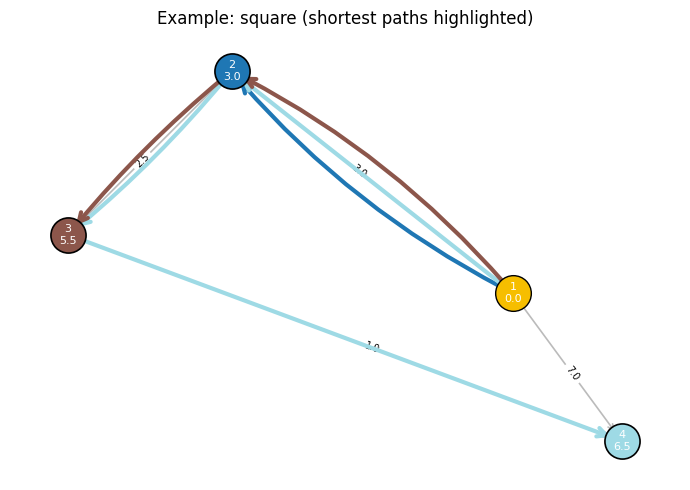

In [14]:
import matplotlib.pyplot as plt


def graphdef_to_nx(graph_def):
    """Convert (node, (neighbors, weight, ...)) tuples into a NetworkX DiGraph."""
    g = nx.DiGraph()
    for node, (neighbors, _dist, _visited, _path) in graph_def:
        g.add_node(node)
        for nbr, w in neighbors:
            g.add_edge(node, nbr, weight=w)
    return g


def visualize_graph(graph_def, title="Graph", distances=None, source_node=None, k=0.9, scale=1.6):
    """Draw layout; annotate distances; highlight each destination path with distinct colors, including overlaps."""
    g = graphdef_to_nx(graph_def)
    pos = nx.spring_layout(g, seed=42, k=k, scale=scale)

    plt.figure(figsize=(7, 5))
    nx.draw_networkx_nodes(g, pos, node_color="#4C78A8", node_size=520, alpha=0.9)
    nx.draw_networkx_edges(g, pos, arrowstyle="->", arrowsize=10, edge_color="#BBBBBB", width=1.2)

    # Labels with distances
    if distances:
        dist_labels = {}
        for node in g.nodes():
            dist = distances.get(node, (None, float("inf"), False, []))[1]
            dist_str = "inf" if dist == float("inf") else f"{dist:.1f}"
            dist_labels[node] = f"{node}\n{dist_str}"
        nx.draw_networkx_labels(g, pos, labels=dist_labels, font_size=8, font_color="white")
    else:
        nx.draw_networkx_labels(g, pos, font_size=8, font_color="white")

    edge_labels = {e: f"{w:.1f}" for e, w in nx.get_edge_attributes(g, "weight").items()}
    nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels, font_size=7, label_pos=0.55)

    # Highlight shortest paths per destination with per-edge multi-color overlays
    if distances:
        destinations = [n for n in g.nodes() if n != source_node and n in distances]
        cmap = plt.cm.get_cmap("tab20", max(len(destinations), 1))
        dest_color = {dest: cmap(i) for i, dest in enumerate(sorted(destinations))}

        edge_color_map = {}  # edge -> list of colors for destinations using it
        paths_per_dest = {}
        for dest in destinations:
            _neighbors, dist, _visited, path = distances.get(dest, (None, float("inf"), False, []))
            if dist == float("inf") or not path or len(path) < 2:
                continue
            paths_per_dest[dest] = path
            for e in zip(path[:-1], path[1:]):
                edge_color_map.setdefault(e, []).append(dest_color[dest])

        # Draw each edge with stacked arcs for multiple colors
        for edge, colors in edge_color_map.items():
            count = len(colors)
            for idx, color in enumerate(colors):
                # spread arcs symmetrically so shared edges show all colors
                rad = (idx - (count - 1) / 2) * 0.1
                nx.draw_networkx_edges(
                    g,
                    pos,
                    edgelist=[edge],
                    width=3.0,
                    edge_color=[color],
                    arrows=True,
                    arrowstyle="->",
                    arrowsize=16,
                    connectionstyle=f"arc3,rad={rad}",
                )

        # Highlight destinations and source
        for dest, path in paths_per_dest.items():
            color = dest_color.get(dest, "#FF5733")
            nx.draw_networkx_nodes(
                g,
                pos,
                nodelist=[dest],
                node_color=[color],
                node_size=640,
                edgecolors="black",
                linewidths=1.2,
            )
        if source_node and source_node in g:
            nx.draw_networkx_nodes(
                g,
                pos,
                nodelist=[source_node],
                node_color="#F6BE00",
                node_size=660,
                edgecolors="black",
                linewidths=1.0,
            )

    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


# Visualize the main road network with distances and colored shortest paths (show shared edges as multi-color arcs)
results_main = run_shortest_paths(pyspark_graph, "A")
visualize_graph(
    pyspark_graph,
    title="Road network from G (shortest paths highlighted)",
    distances=results_main,
    source_node="A",
    k=1.0,
    scale=2.0,
)

# Visualize the small examples with distances and colored shortest paths (shared edges shown with multiple arcs)
for name, graph_def in extra_examples.items():
    results = run_shortest_paths(graph_def, "1")
    visualize_graph(
        graph_def,
        title=f"Example: {name} (shortest paths highlighted)",
        distances=results,
        source_node="1",
        k=0.9,
        scale=1.5,
    )
